In [1]:
# Visualize intermediate activations (output of intermediate layers)

# load a saved model
from keras.models import load_model

model=load_model('cats_and_dogs_small_2.h5')
model.summary()

D:\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [2]:
# preprocess a single image
img_path='/Users/think/Downloads/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img=image.load_img(img_path, target_size=(150,150))
img_tensor=image.img_to_array(img)
img_tensor=np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


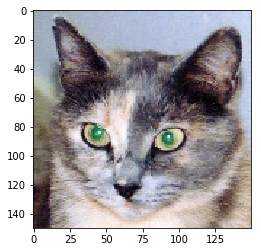

In [3]:
# display the test picture
% matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])

In [4]:
# Instantiate a model from an input tensor and a list of output tensors
from keras import models

# extract the outputs of the top 8 layers
layer_outputs=[layer.output for layer in model.layers[:8]]
# create a model that will return thses outputs
activation_model=models.Model(inputs=model.input, outputs=layer_outputs)
# this will return a list of 5 Numpy arrays, one array per layer activation
activations=activation_model.predict(img_tensor)

# it's a 148x148 feature map with 32 channels
first_layer_activation=activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


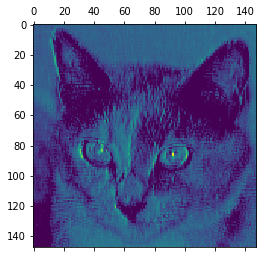

In [5]:
# visualize the 4th channel
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0,:,:,4], cmap='viridis')

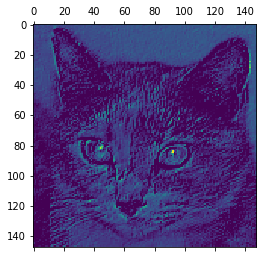

In [6]:
plt.matshow(first_layer_activation[0,:,:,7], cmap='viridis')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


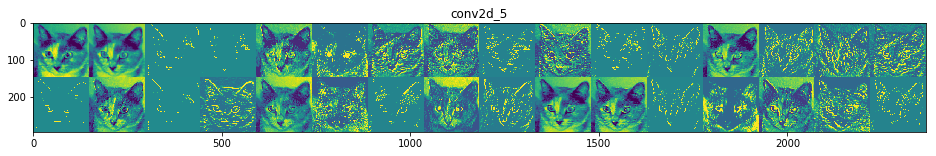

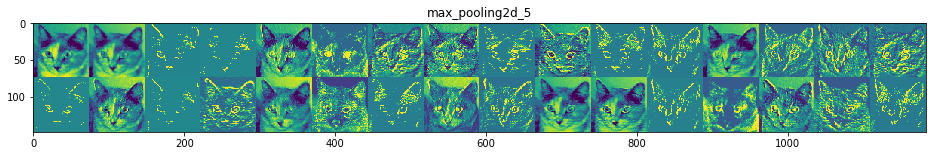

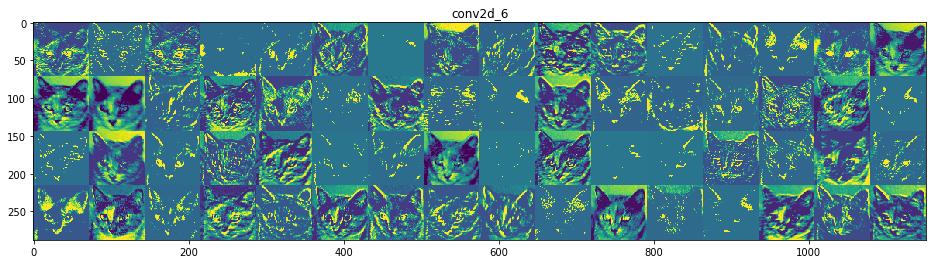

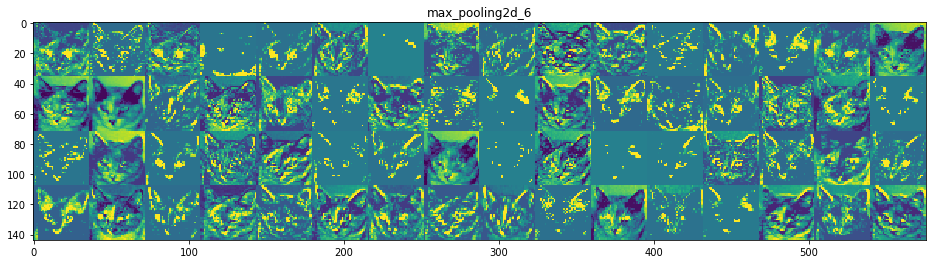

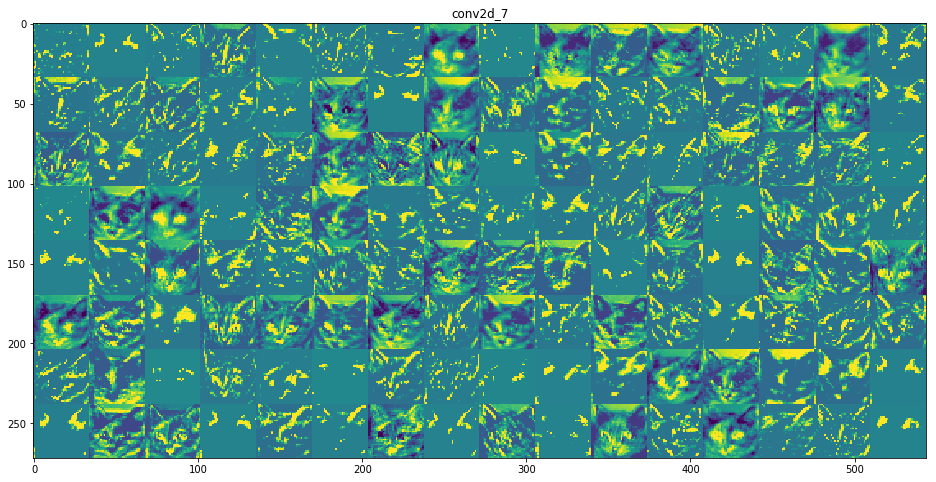

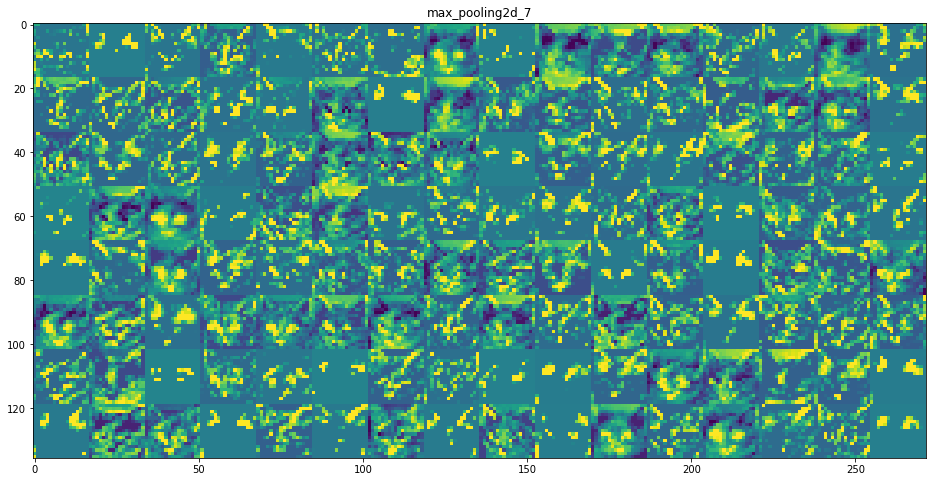

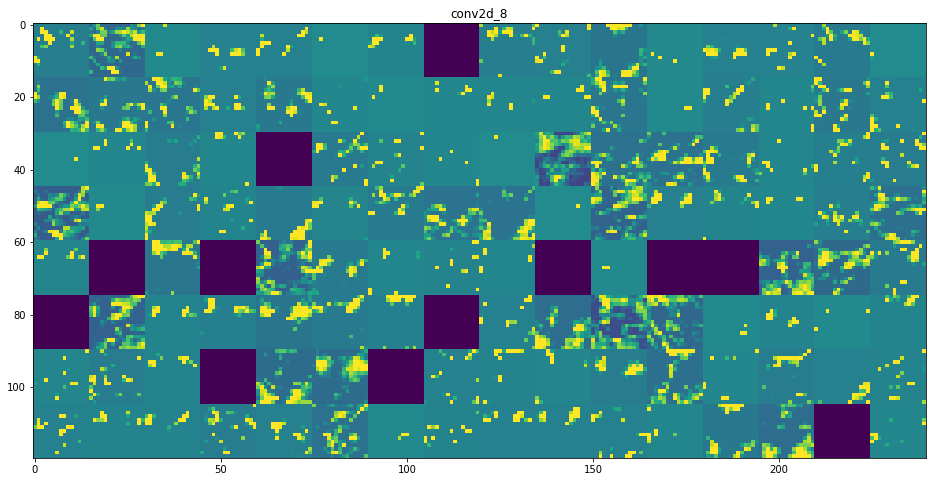

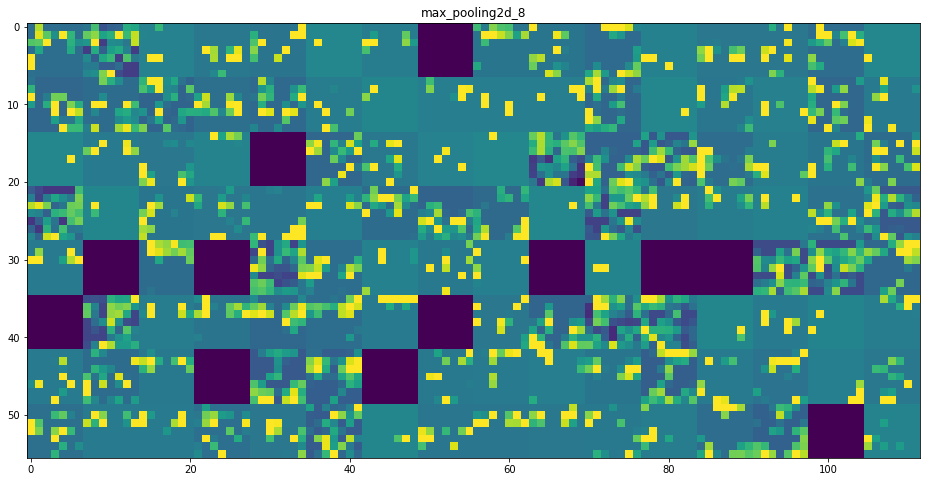

In [7]:
# visualize every channel in every intermediate activation
layer_names=[]
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row=16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features=layer_activation.shape[-1]
    # the feature map has shape (1, size, size, n_features)
    size=layer_activation.shape[1]
    # tile the activation channels in this matrix
    n_cols=n_features//images_per_row
    display_grid=np.zeros((size*n_cols, images_per_row*size))
    # tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image=layer_activation[0,:,:,col*images_per_row+row]
            # post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size:(col+1)*size, row*size:(row+1)*size] = channel_image
    
    # display the grid
    scale=1./size
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [8]:
# Visualize convnet filters (the visual pattern that each filter is meant to respond to)

# Steps:
# 1. build a loss function that maximizes the value of a given filter
# 2. use stochastic gradient descent to adjust the values of the input image in order to maximize this activation value

# define the loss tensor for filter visualization
from keras.applications import VGG16
from keras import backend as K

model=VGG16(weights='imagenet', include_top=False)
layer_name='block3_conv1'
filter_index=0

In [9]:
# utility function to convert a tensor into a valid image
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std()+1e-5)
    x *= 0.1
    
    # clip to [0,1]
    x += 0.5
    x = np.clip(x,0,1)
    
    # convert to RGB array
    x *= 255
    x = np.clip(x,0,255).astype('uint8')
    return x

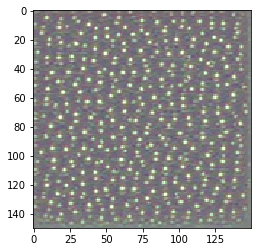

In [10]:
# a function to generate filter visualizations
def generate_pattern(layer_name, filter_index, size):
    layer_output=model.get_layer(layer_name).output
    loss=K.mean(layer_output[:,:,:,filter_index])
    
    # compute the gradient of the input picture wrt this loss
    grads=K.gradients(loss, model.input)[0]
    
    # the gradient normalization trick
    grads /= (K.sqrt(K.mean(K.square(grads)))+1e-5)
    
    # define a function for fetchin Numpy output values
    iterate=K.function([model.input],[loss,grads])
    
    # loss maximization via stochastic gradient descent over the input parameters
    # start from a gray image with some noise
    input_img_data=np.random.random((1,size,size,3))*20+128
    # run gradient ascent for 40 steps
    step=1.
    for i in range(40):
        loss_value,grads_value=iterate([input_img_data])
        # adjust the input image in the direction that maximizes the loss
        input_img_data += grads_value*step
        
    img=input_img_data[0]
    return deprocess_image(img)

plt.imshow(generate_pattern('block3_conv1',0, 150))

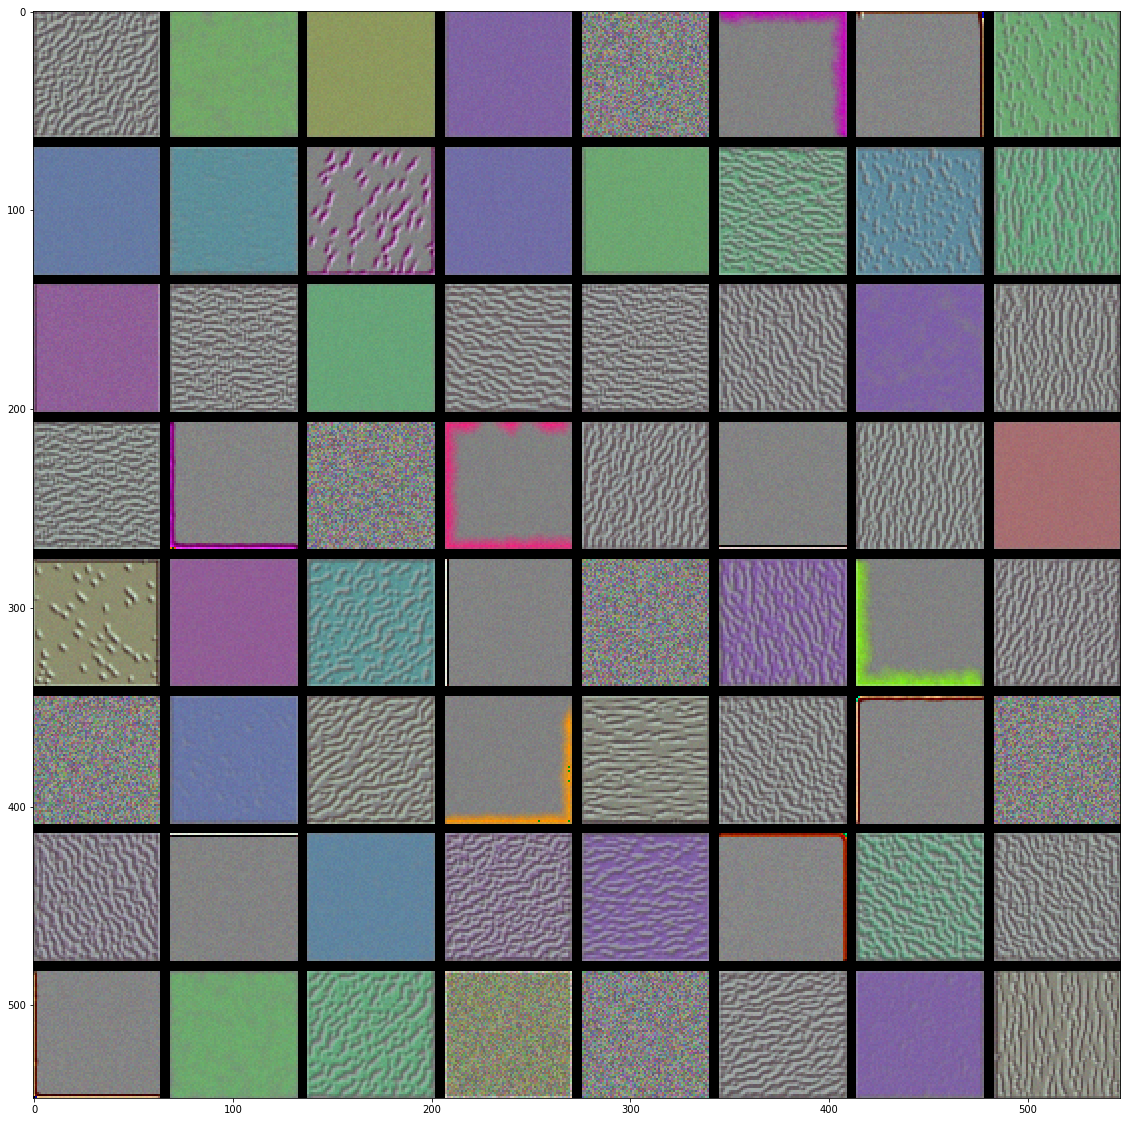

In [11]:
# generate grid of all filter response patterns in a layer
layer_name='block1_conv1'
size=64
margin=5

results=np.zeros((8*size+7*margin, 8*size+7*margin, 3))

for i in range(8):
    for j in range(8):
        filter_img=generate_pattern(layer_name, i+(j*8), size=size)
        
        horizontal_start=i*size+i*margin
        horizontal_end=horizontal_start+size
        vertical_start=j*size+j*margin
        vertical_end=vertical_start+size
        
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :]=filter_img

plt.figure(figsize=(20,20))
plt.imshow(results)

In [17]:
# Visualize hearmaps of class activation

# load the VVG16 network with pre-trained weights
from keras.applications.vgg16 import VGG16

model=VGG16(weights='imagenet')

553467904/553467096 [==============================] - 197s 0us/step


In [18]:
# preprocess the input image
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path='/Users/think/Downloads/creative_commons_elephant.jpg'
img=image.load_img(img_path, target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
# dose channel-wise color normalization
x=preprocess_input(x)

In [19]:
# predict the class
preds=model.predict(x)
print('Predicted:',decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 1s 13us/step
Predicted: [('n02504458', 'African_elephant', 0.9048642), ('n01871265', 'tusker', 0.08730035), ('n02504013', 'Indian_elephant', 0.0070190993)]


In [20]:
np.argmax(preds[0])

386

In [21]:
# set up the Grad-CAM algorithm

# the 'african elephant' entry in the prediction vector
african_elephant_output=model.output[:,386]
# the last convolutional layer in VGG16
last_conv_layer=model.get_layer('block5_conv3')
# the gradient of the 'african elephant' class
grads=K.gradients(african_elephant_output, last_conv_layer.output)[0]
# a vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature map channel
pooled_grads=K.mean(grads, axis=(0,1,2))

iterate=K.function([model.input],[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value=iterate([x])

# multiply each channel in the feature map array by 'how important this channel is' with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
# the channel-wise mean of the resulting feature map is our heatmap of class activation
heatmap=np.mean(conv_layer_output_value, axis=-1)

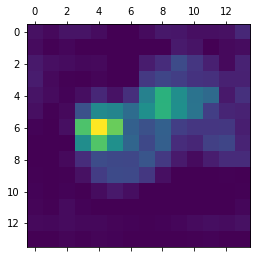

In [22]:
# heatmap post-process
heatmap=np.maximum(heatmap,0)
heatmap/=np.max(heatmap)
plt.matshow(heatmap)

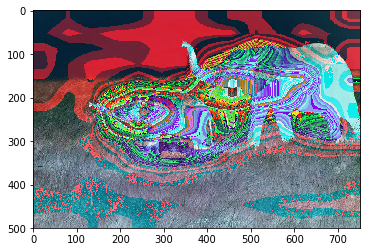

In [27]:
# superimpose the heatmap with the original picture
import cv2

img=cv2.imread(img_path)
heatmap=cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap=np.uint8(255*heatmap)
heatmap=cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img=heatmap*0.4+img
cv2.imwrite('/Users/think/Downloads/elephant_cam.jpg', superimposed_img)
plt.imshow(superimposed_img)